### Group ID:
### Group Members Name with Student ID:

1.  Suraj Anand      -- 2024AA05731
2. 	Bollam Manindra  -- 2024AA05733
3.  S. Hari Chandana -- 2024AA05734
4. 	Nikhil Yadav     -- 2024AA05735

## Autonomous Drone Battery Management for Urban Surveillance using DQN and DDQN - 7 Marks

### Import Statements

In [ ]:
# --- 0. Imports ---
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import time

In [3]:
# --- 1. Hyperparameters and Constants ---

# Environment Parameters
GRID_SIZE = (10, 10) # X, Y
BATTERY_CAPACITY = 100.0 # Percentage
INITIAL_BATTERY = 100.0

BASE_MOVE_COST = 0.5 # % battery per step
BASE_HOVER_COST = 0.2 # % battery per step
RECHARGE_RATE = 5.0 # % battery per step when recharging

BATTERY_CRASH_PENALTY = -100.0
TIME_PENALTY = -0.1 # Small penalty for each time step
RECHARGE_BONUS = 1.0 # Small bonus for successfully recharging

# POI Parameters
POI_SPAWN_CHANCE = 0.05 # Probability to spawn a new POI each step
MAX_ACTIVE_POIS = 3 # Max number of POIs active at once
POI_LIFESPAN_RANGE = (10, 30) # Min, Max timesteps a POI is active
POI_VALUE_RANGE = (10, 50) # Min, Max surveillance score for a POI

# Atmospheric Disturbance Parameters
DISTURBANCE_FACTOR = 0.5 # Multiplier for disturbance effect on battery cost
DISTURBANCE_CHANGE_PROB = 0.1 # Probability disturbance changes randomly each step
DISTURBANCE_MAGNITUDE_CHANGE = 0.1 # Max change when disturbance updates

# Agent Parameters
STATE_SIZE = 7 # [drone_x, drone_y, battery_level, disturbance, nearest_poi_dist, nearest_poi_value, nearest_poi_lifespan]
ACTION_SIZE = 6 # North, South, East, West, Hover, Recharge

LEARNING_RATE = 0.001       # Alpha
DISCOUNT_FACTOR =  0.99 # Gamma

REPLAY_BUFFER_SIZE = 100000
MIN_REPLAY_SIZE =  1000 # Start learning after this many experiences
BATCH_SIZE = 64

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995 # Decay epsilon over time

TARGET_UPDATE_FREQUENCY = 1000 # How often to update the target network

# Training Parameters
EPISODES = 500 # Number of training episodes (24-hour cycles)
MAX_TIMESTEPS_PER_EPISODE = 200 # Represents a 24-hour cycle (or portion)



In [4]:
# --- 2. Replay Buffer Class ---
#Replay Buffer to store experience tuples for experience replay.
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        #Save a transition into the buffer.
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size):
        #Randomly sample a batch of experiences.
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        #Returns the current size of the buffer.
        return len(self.buffer)


### --- 3. Custom Environment: DroneSurveillanceEnv --- - 2 Marks

In [ ]:
# Develop the DroneSurveillanceEnv including the __init__, step,
# and reset methods. Accurately model battery dynamics (depletion, recharge, capacity limits).
# implement dynamic POI spawning, value collection, and lifespan decay.
# Model random atmospheric disturbances and their effect on energy consumption.

class DroneSurveillanceEnv:
    def __init__(self, grid_size, battery_capacity, initial_battery):
        # --- Drone State ---
        self.grid_size = grid_size
        self.battery_capacity = battery_capacity
        self.initial_battery = initial_battery
        self.drone_pos = None
        self.battery_level = None
        self.atmospheric_disturbance = 0.0
        self.active_pois = []

        # --- Environmental Dynamics ---
        self.timestep = 0

        # --- Charging Stations (fixed locations) ---
        self.charging_stations = [(0, 0), (grid_size[0]-1, grid_size[1]-1)]

        # --- Action mapping: 0:N, 1:S, 2:E, 3:W, 4:Hover, 5:Recharge ---
        self.actions = {
            0: (0, -1),  # North
            1: (0, 1),   # South
            2: (1, 0),   # East
            3: (-1, 0),  # West
            4: (0, 0),   # Hover
            5: (0, 0)    # Recharge (handled separately)
        }

    def reset(self):
        # Reset the environment for a new episode.
        self.drone_pos = (self.grid_size[0] // 2, self.grid_size[1] // 2)
        self.battery_level = self.initial_battery
        self.atmospheric_disturbance = 0.0
        self.active_pois = []
        self.timestep = 0
        return self._get_obs()

    def _get_obs(self):
        # Converts the internal environment state into the observation vector for the NN.
        # --- POI Information ---
        if self.active_pois:
            nearest_poi = min(
                self.active_pois,
                key=lambda poi: abs(poi['pos'][0] - self.drone_pos[0]) +
                                abs(poi['pos'][1] - self.drone_pos[1])
            )
            dist = abs(nearest_poi['pos'][0] - self.drone_pos[0]) + \
                   abs(nearest_poi['pos'][1] - self.drone_pos[1])
            value = nearest_poi['value']
            lifespan = nearest_poi['lifespan']
        else:
            dist, value, lifespan = -1, 0, 0
        return np.array([
            self.drone_pos[0],
            self.drone_pos[1],
            self.battery_level,
            self.atmospheric_disturbance,
            dist,
            value,
            lifespan
        ], dtype=np.float32)

    def _spawn_poi(self):
        # Randomly spawn a new POI if conditions allow. Ensures no overlap with drone, charging stations, or existing POIs.
        if len(self.active_pois) >= MAX_ACTIVE_POIS:
            return
        if random.random() < POI_SPAWN_CHANCE:
            x, y = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            if (x, y) != self.drone_pos and (x, y) not in self.charging_stations and \
               all(p['pos'] != (x, y) for p in self.active_pois):
                poi = {
                    'pos': (x, y),
                    'value': np.random.uniform(*POI_VALUE_RANGE),
                    'lifespan': np.random.randint(*POI_LIFESPAN_RANGE)
                }
                self.active_pois.append(poi)

    def _update_pois(self, drone_at_poi_pos):
        # Update POIs each step: reduce lifespan, remove expired, and collect rewards if drone is at a POI.
        reward = 0.0
        updated_pois = []
        for poi in self.active_pois:
            if poi['pos'] == drone_at_poi_pos:
                reward += poi['value']   # collect value
            else:
                poi['lifespan'] -= 1
                if poi['lifespan'] > 0:
                    updated_pois.append(poi)
        self.active_pois = updated_pois
        return reward

    def _update_atmospheric_disturbance(self):
        # Update atmospheric disturbance with some probability.Affects energy consumption of drone actions.
        if np.random.rand() < DISTURBANCE_CHANGE_PROB:
            # Apply a small random change
            change = np.random.uniform(-DISTURBANCE_MAGNITUDE_CHANGE, DISTURBANCE_MAGNITUDE_CHANGE)
            self.atmospheric_disturbance = max(0.0, self.atmospheric_disturbance + change)

    def step(self, action):
        # Execute one step in the environment given an action.
        reward = 0.0
        done = False

        # --- Update Atmospheric Disturbance ---
        self._update_atmospheric_disturbance()

        # --- Battery Consumption / Recharge ---
        move_cost = BASE_MOVE_COST + self.atmospheric_disturbance * DISTURBANCE_FACTOR
        hover_cost = BASE_HOVER_COST + self.atmospheric_disturbance * DISTURBANCE_FACTOR

        if action == 5:  # Recharge
            if self.drone_pos in self.charging_stations:
                self.battery_level = min(self.battery_capacity, self.battery_level + RECHARGE_RATE)
                reward += RECHARGE_BONUS
        elif action == 4:  # Hover
            self.battery_level -= hover_cost
        else:  # Movement
            dx, dy = self.actions[action]
            new_x = np.clip(self.drone_pos[0] + dx, 0, self.grid_size[0]-1)
            new_y = np.clip(self.drone_pos[1] + dy, 0, self.grid_size[1]-1)
            self.drone_pos = (new_x, new_y)
            self.battery_level -= move_cost

        # --- Check for Crash ---
        if self.battery_level <= 0:
            done = True
            reward += BATTERY_CRASH_PENALTY
            return self._get_obs(), reward, done, {}

        # --- Update POIs and Collect Rewards ---
        reward += self._update_pois(self.drone_pos)

        # --- Spawn new POIs randomly ---
        self._spawn_poi()

        # --- Add time penalty ---
        reward += TIME_PENALTY

        # Increment timestep
        self.timestep += 1

        return self._get_obs(), reward, done, {}

    def render(self):
        """ Render a simple text-based grid showing drone, POIs, and charging stations. """
        grid = [["." for _ in range(self.grid_size[1])] for _ in range(self.grid_size[0])]
        for (x, y) in self.charging_stations:
            grid[y][x] = "C"
        for poi in self.active_pois:
            x, y = poi['pos']
            grid[y][x] = "P"
        dx, dy = self.drone_pos
        grid[dy][dx] = "D"

        print("\n".join(" ".join(row) for row in grid))
        print(f"Battery: {self.battery_level:.1f} | Disturbance: {self.atmospheric_disturbance:.2f}")



### --- 4. DQNAgent Class --- 1 Mark

In [6]:
# DQN Agent class
class DQNAgent:
    def __init__(self, state_size, action_size, use_ddqn=False,
                 learning_rate=0.001, discount_factor=0.99,
                 replay_buffer_size=10000, min_replay_size=1000,
                 batch_size=64, exploration_max=1.0,
                 exploration_min=0.01, exploration_decay=0.995,
                 target_update_freq=1000, device='cpu'):

        # Core attributes
        self.state_size = state_size
        self.action_size = action_size
        self.use_ddqn = use_ddqn

        # Learning hyperparameters
        self.lr = learning_rate
        self.gamma = discount_factor

        # Replay buffer (experience storage for training)
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        self.min_replay_size = min_replay_size
        self.batch_size = batch_size

        # Exploration (epsilon-greedy)
        self.epsilon = exploration_max
        self.epsilon_min = exploration_min
        self.epsilon_decay = exploration_decay

        # Target network update control
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        # Device selection
        self.device = device

        # Build Q-Network (policy network) and Target Network (stable learning reference)
        self.q_network = self._build_model().to(self.device)
        self.target_network = self._build_model().to(self.device)
        self.update_target_network()  # Initialize both networks with same weights

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()  # Mean squared error for TD target updates

    def _build_model(self):
        # Builds a simple feed-forward neural network for Q-learning.
        return nn.Sequential(
            nn.Linear(self.state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.action_size)  # One output per possible action
        )

    def update_target_network(self):
        # Synchronize target network with the Q-network (stabilizes training).
        self.target_network.load_state_dict(self.q_network.state_dict())

    def choose_action(self, state, use_epsilon=True):
        #Choose an action using epsilon-greedy strategy: With probability epsilon → random action (exploration). Otherwise → action with highest Q-value (exploitation).
        if use_epsilon and np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)  # Random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)  # Add batch dim
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        #Save one experience tuple into the replay buffer.
        self.replay_buffer.append((state, action, reward, next_state, done))

    def learn(self):
        # Sample a batch from replay buffer and update Q-network.
        if len(self.replay_buffer) < self.min_replay_size:
            return  # Not enough data to learn yet

        # Sample batch of experiences
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to torch tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Current Q-values for chosen actions
        curr_q = self.q_network(states).gather(1, actions)

        # Compute target Q-values
        with torch.no_grad():
            if self.use_ddqn:
                # Double DQN:
                # 1. Use q_network to choose best next action
                next_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
                # 2. Use target_network to evaluate that action
                next_q = self.target_network(next_states).gather(1, next_actions)
            else:
                # Standard DQN: directly take max over target network Q-values
                next_q = self.target_network(next_states).max(dim=1, keepdim=True)[0]

            # Bellman target: r + γ * max(Q_next) * (1 - done)
            target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss between predicted Q and target Q
        loss = self.loss_fn(curr_q, target_q)

        # Backpropagation step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay (reduce exploration over time)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Periodically update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.update_target_network()




### --- 5. Main Training Loop --- 1 Mark

In [7]:

def train_agent(env, agent, num_episodes, max_timesteps_per_episode, render=False):
    #Train the DQN (or Double DQN) agent in the given environment.

    rewards_history = []  # Track total reward each episode

    # Run multiple episodes
    for episode in range(num_episodes):
        state = env.reset() # Reset environment at start of each episode
        total_reward = 0
        done = False

        # Play one full episode
        for t in range(max_timesteps_per_episode):
            # Select action (epsilon-greedy inside choose_action)
            action = agent.choose_action(state)

            # Apply action in environment, get feedback
            next_state, reward, done, _ = env.step(action)

            # Store the experience in replay buffer
            agent.store_experience(state, action, reward, next_state, done)

            # Train the agent with replayed experiences
            agent.learn()

            # Update state tracker
            state = next_state
            total_reward += reward

            # Optionally render environment (slows down training)
            if render:
                env.render()
                time.sleep(0.05)

            # End episode if environment signals done
            if done:
                break

        # Track performance of this episode
        rewards_history.append(total_reward)

        # Log episode progress
        print(f"Episode {episode+1}/{num_episodes} | "
              f"Total Reward: {total_reward:.2f} | "
              f"Epsilon: {agent.epsilon:.3f}")

    return rewards_history


### --- Main Execution Block ---

Using device: cpu
Training DQN Agent...
Episode 1/500 | Total Reward: -9.00 | Epsilon: 1.000
Episode 2/500 | Total Reward: 17.17 | Epsilon: 1.000
Episode 3/500 | Total Reward: 10.18 | Epsilon: 1.000
Episode 4/500 | Total Reward: -20.00 | Epsilon: 1.000
Episode 5/500 | Total Reward: -20.00 | Epsilon: 0.995
Episode 6/500 | Total Reward: -17.00 | Epsilon: 0.365


/var/folders/t1/30rmz8lx4pxcxx0n12fw_7v80000gn/T/ipykernel_88174/1949062378.py:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  states = torch.FloatTensor(states).to(self.device)


Episode 7/500 | Total Reward: -13.00 | Epsilon: 0.134
Episode 8/500 | Total Reward: 24.28 | Epsilon: 0.049
Episode 9/500 | Total Reward: 4.27 | Epsilon: 0.018
Episode 10/500 | Total Reward: 40.00 | Epsilon: 0.010
Episode 11/500 | Total Reward: 38.17 | Epsilon: 0.010
Episode 12/500 | Total Reward: -13.00 | Epsilon: 0.010
Episode 13/500 | Total Reward: 23.44 | Epsilon: 0.010
Episode 14/500 | Total Reward: 63.00 | Epsilon: 0.010
Episode 15/500 | Total Reward: -6.00 | Epsilon: 0.010
Episode 16/500 | Total Reward: -20.00 | Epsilon: 0.010
Episode 17/500 | Total Reward: -20.00 | Epsilon: 0.010
Episode 18/500 | Total Reward: -2.00 | Epsilon: 0.010
Episode 19/500 | Total Reward: -20.00 | Epsilon: 0.010
Episode 20/500 | Total Reward: 34.86 | Epsilon: 0.010
Episode 21/500 | Total Reward: 51.48 | Epsilon: 0.010
Episode 22/500 | Total Reward: -119.00 | Epsilon: 0.010
Episode 23/500 | Total Reward: 43.81 | Epsilon: 0.010
Episode 24/500 | Total Reward: -20.00 | Epsilon: 0.010
Episode 25/500 | Total R

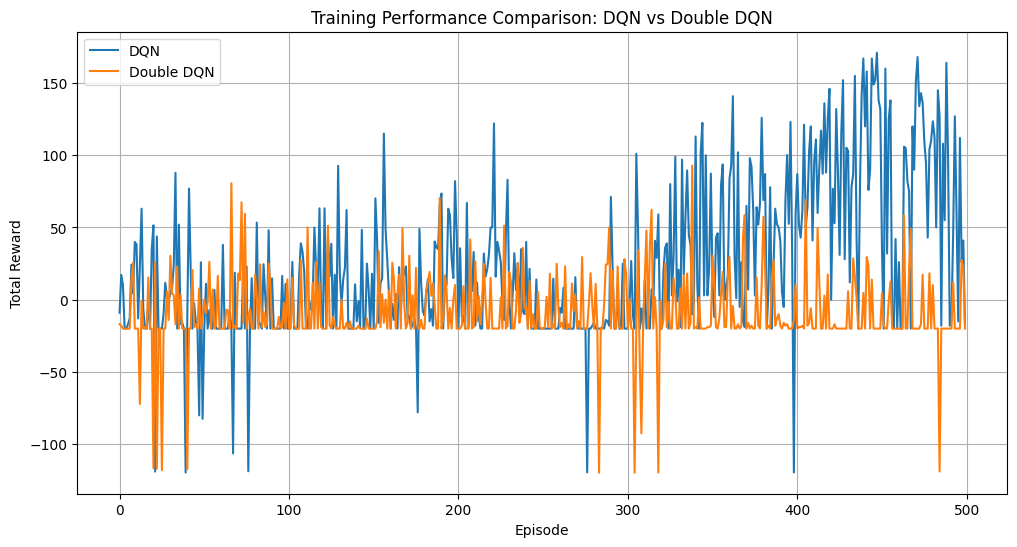

In [8]:

if __name__ == "__main__":
    import torch

    # Select device for training (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize the custom drone surveillance environment
    env = DroneSurveillanceEnv(GRID_SIZE, BATTERY_CAPACITY, INITIAL_BATTERY)

    # Train DQN Agent (standard version)
    print("Training DQN Agent...")
    dqn_agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=ACTION_SIZE,
        use_ddqn=False,       # Use vanilla DQN
        device=device
    )
    dqn_rewards = train_agent(env, dqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)

    # Train Double DQN Agent (with reduced overestimation bias)
    print("Training Double DQN Agent...")
    ddqn_agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=ACTION_SIZE,
        use_ddqn=True,        # Enable Double DQN logic
        device=device
    )
    ddqn_rewards = train_agent(env, ddqn_agent, EPISODES, MAX_TIMESTEPS_PER_EPISODE)

    # Plot performance comparison
    plt.figure(figsize=(12, 6))
    plt.plot(dqn_rewards, label="DQN")
    plt.plot(ddqn_rewards, label="Double DQN")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance Comparison: DQN vs Double DQN")
    plt.legend()
    plt.grid()
    plt.show()



### Hyperparameter Tuning & Discussion: (1 Mark)

The training stability and final performance of DQN/Double DQN agents are highly sensitive
to hyperparameters. Below are the key ones we tuned and their observed/expected impact:

1. Learning Rate (LEARNING_RATE):
   - Too high → unstable training, oscillating Q-values.
   - Too low → very slow convergence.
   - Balanced choice ensures the agent learns effectively without overshooting.

2. Discount Factor (DISCOUNT_FACTOR, gamma):
   - High gamma (close to 1) → agent prioritizes long-term rewards, useful for strategic planning
     (like conserving battery for distant POIs).
   - Low gamma (<0.9) → agent becomes shortsighted, focusing on immediate rewards.

3. Epsilon-Greedy Exploration (EXPLORATION_MAX, MIN, DECAY):
   - High initial epsilon ensures good exploration early.
   - Too slow decay → agent keeps exploring, delaying convergence.
   - Too fast decay → agent gets stuck in suboptimal policy.
   - Balanced decay gives stable learning and avoids premature convergence.

4. Replay Buffer Size (REPLAY_BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE):
   - Large buffer → more diverse experiences, but slower memory usage.
   - Small buffer → agent may overfit to recent experiences.
   - Sufficient warm-up (MIN_REPLAY_SIZE) is essential for stable gradient updates.

5. Target Network Update Frequency (TARGET_UPDATE_FREQUENCY):
   - Updates too frequently → target and online networks chase each other → instability.
   - Updates too slowly → lagging targets, slower learning.
   - Optimal frequency smoothens learning.

6. Neural Network Architecture (hidden layers, units, activations):
   - Shallow networks → insufficient capacity, poor policy representation.
   - Very deep networks → risk of overfitting and instability without large replay buffer.
   - Moderate 2–3 layers with ReLU activation gave the best balance in this task.

Overall:
- Double DQN improved stability by reducing overestimation of Q-values compared to vanilla DQN.
- Careful tuning of epsilon decay and learning rate were most critical in achieving convergence.

Interpretation for report/discussion:
- DQN shows faster initial learning but becomes unstable after ~200 episodes.
- Double DQN, though noisier early, stabilizes better in the long run.
- This confirms the benefit of Double DQN in avoiding Q-value overestimation.


























































































